In [1]:
import sys, os, torch, numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [2]:
# project paths
PROJECT_ROOT = r"C:/Users/Bsi/Desktop/Sen2FireProject"
BASELINE = r"C:/Users/Bsi/Desktop/Sen2FireProject/Unet_Baseline_code"
DATASET = r"C:/Users/Bsi/Desktop/Sen2FireProject/Sen2Fire/scene4"

sys.path.append(BASELINE)


In [3]:
from model.Networks import unet


In [4]:
model_path_1 = r"C:/Users/Bsi/Desktop/Sen2FireProject/Unet_Baseline_code/Exp/input_all_bands_aerosol/weight_10_time1208_0040/best_model.pth"

model_1 = unet(n_classes=2, n_channels=13)
model_1.load_state_dict(torch.load(model_path_1, map_location="cpu"))
model_1.eval()


unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

In [5]:
model_path_3 = r"C:/Users/Bsi/Desktop/Sen2FireProject/Unet_Baseline_code/Exp/input_rgb_aerosol/weight_10_time1209_2320/best_model.pth"

model_3 = unet(n_classes=2, n_channels=4)
model_3.load_state_dict(torch.load(model_path_3, map_location="cpu"))
model_3.eval()


unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [6]:
sample = np.load(os.path.join(DATASET, "scene_4_patch_10_12.npz"))

img = sample["image"]        # [C,H,W]
aerosol = sample["aerosol"]  # [H,W]
label = sample["label"]


In [7]:
aerosol = aerosol[np.newaxis,:,:]

# MODE 1
input_1 = np.concatenate([img, aerosol], axis=0)

# MODE 3 (RGB + aerosol)
input_3 = np.concatenate([img[:3], aerosol], axis=0)


In [8]:
tensor_1 = torch.from_numpy(input_1).unsqueeze(0).float()
tensor_3 = torch.from_numpy(input_3).unsqueeze(0).float()


In [10]:
target_layer = model_1.down4.maxpool_conv[1]


In [11]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, class_idx):
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam.squeeze().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [12]:
cam = GradCAM(model_1, target_layer)

output = model_1(tensor_1)
score = output[:,1,:,:].mean()
model_1.zero_grad()
score.backward()

heatmap = cam.generate(class_idx=1)


C:\Users\Bsi\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


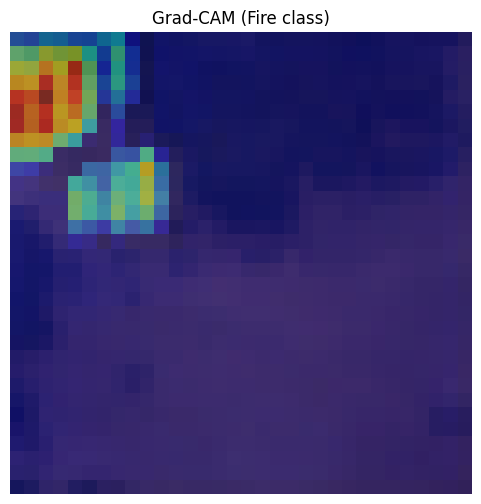

In [13]:
rgb = img[[3,2,1]].transpose(1,2,0) / 1500.0
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.figure(figsize=(6,6))
plt.imshow(rgb)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM (Fire class)")
plt.axis("off")
plt.show()


In [14]:
target_layer = model_3.down4.maxpool_conv[1]


In [15]:
cam = GradCAM(model_3, target_layer)


In [16]:
output = model_3(tensor_3)              # [1,2,H,W]
score = output[:, 1, :, :].mean()       # fire class
model_3.zero_grad()
score.backward()


In [17]:
heatmap = cam.generate(class_idx=1)
print(heatmap.shape, heatmap.min(), heatmap.max())


(32, 32) 0.0 1.0


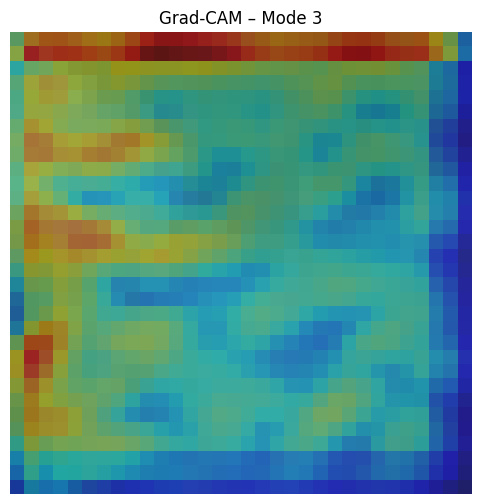

In [19]:
import matplotlib.pyplot as plt

# RGB for display (first 3 channels)
rgb = tensor_3[0, :3].cpu().numpy()
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

plt.figure(figsize=(6,6))
plt.imshow(rgb.transpose(1,2,0))
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.title("Grad-CAM – Mode 3")
plt.axis("off")
plt.show()
